## Notes

### Overview
This notebook captures a series of efforts to apply signal processing techniques to imu sensor data recorded from a small 4-wheel motor-driven car.  The main objectives are:
- Demonstrate a data processing pipeline that can estimate vehicle position from measurements of acceleration estimates

### TODO
- Rerun test with 10ms sampling interval (might be missing some acceleration)
 - Can't reliably sample at 10ms with dropping samples (maybe will work better in C)
- Rerun test and filtering with quaternian transforms applied before filtering
- Look at spectrogram of acceleration signals
- Do I need to integrate full complex signals or are integrals of magnitude sufficient?

In [152]:
%matplotlib inline
from __future__ import division
import time
import datetime
from scipy import signal
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [161]:
# - Plotting helper for several experiments
def plot_raw_and_processed_data(
    raw_data,
    filtered_data=None,
    title_extra_str='',
    ylim=None,
    y1lim=None,
    y2lim=None,
    y3lim=None):
    
    do_filtered_data = False
    if filtered_data is not None:
        do_filtered_data = True
        filt_data_x = filtered_data.x
        filt_data_y = filtered_data.y
        filt_data_z = filtered_data.z
    
    sig_data_x = raw_data.x
    sig_data_y = raw_data.y
    sig_data_z = raw_data.z

    

    fig, axes = plt.subplots(figsize=(8,10),nrows=3, ncols=1)

    current_axes = axes[0]
    current_axes.plot(sig_data_x, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filt_data_x, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('{0} - X'.format(title_extra_str), fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if ylim is not None:
        current_axes.set_ylim(ylim)
    if y1lim is not None:
        current_axes.set_ylim(y1lim)
    current_axes.legend(loc='upper left')

    current_axes = axes[1]
    current_axes.plot(sig_data_y, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filt_data_y, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('{0} - Y'.format(title_extra_str), fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if ylim is not None:
        current_axes.set_ylim(ylim)
    if y2lim is not None:
        current_axes.set_ylim(y2lim)
    current_axes.legend(loc='upper left')

    current_axes = axes[2]
    current_axes.plot(sig_data_z, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filt_data_z, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('{0} - Z'.format(title_extra_str), fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if ylim is not None:
        current_axes.set_ylim(ylim)
    if y3lim is not None:
        current_axes.set_ylim(y3lim)
    current_axes.legend(loc='upper left')
    
# - Plotting helper for several experiments
def plot_spectrograms(
    time_domain_data,
    sampling_interval,
    title_extra_str='',
    do_log_scale=False,
    ylim=None,
    y1lim=None,
    y2lim=None,
    y3lim=None):
    
    fig, axes = plt.subplots(figsize=(8,10),nrows=3, ncols=1)
    
    freq_data, x_data = signal.periodogram(time_domain_data.x,fs=1/sampling_interval,scaling='density')
    freq_data, y_data = signal.periodogram(time_domain_data.y,fs=1/sampling_interval,scaling='density')
    freq_data, z_data = signal.periodogram(time_domain_data.z,fs=1/sampling_interval,scaling='density')

    current_axes = axes[0]
    current_axes.plot(freq_data,x_data, linestyle='-', color='b', linewidth=2, alpha=0.5, label='raw')
    current_axes.set_title('{0} - X'.format(title_extra_str), fontsize=8)
    #current_axes.set_xlabel('Frequency [Hz]', fontsize=10)
    #current_axes.set_ylabel('Signals', fontsize=10)
    if do_log_scale:
        current_axes.set_yscale('log')
    if ylim is not None:
        current_axes.set_ylim(ylim)
    if y1lim is not None:
        current_axes.set_ylim(y1lim)
    #current_axes.legend(loc='upper left')

    current_axes = axes[1]
    current_axes.plot(freq_data,y_data, linestyle='-', color='b', linewidth=2, alpha=0.5, label='raw')
    current_axes.set_title('{0} - Y'.format(title_extra_str), fontsize=8)
    #current_axes.set_xlabel('Frequency [Hz]', fontsize=10)
    #current_axes.set_ylabel('Signals', fontsize=10)
    if do_log_scale:
        current_axes.set_yscale('log')
    if ylim is not None:
        current_axes.set_ylim(ylim)
    if y2lim is not None:
        current_axes.set_ylim(y2lim)
    #current_axes.legend(loc='upper left')

    current_axes = axes[2]
    current_axes.plot(freq_data,z_data, linestyle='-', color='b', linewidth=2, alpha=0.5, label='raw')
    current_axes.set_title('{0} - Z'.format(title_extra_str), fontsize=8)
    current_axes.set_xlabel('Frequency [Hz]', fontsize=10)
    #current_axes.set_ylabel('Signals', fontsize=10)
    if do_log_scale:
        current_axes.set_yscale('log')
    if ylim is not None:
        current_axes.set_ylim(ylim)
    if y3lim is not None:
        current_axes.set_ylim(y3lim)
    #current_axes.legend(loc='upper left')

In [153]:
data_path = '/home/pi/nanibot/sandboxes/data/'

# --- Test 3d ---
# 25% pwr forward for 2 sec
# stop, wait 2 sec
# 25% pwr backward for 2 sec
# stop
#data_name = 'rover_imu_test_data_Test3d_20170110_035946.csv'
#data_name = 'rover_imu_test_data_Test3d_20170110_040156.csv'
#data_name = 'rover_imu_test_data_Test3d_20170110_040330.csv'
#data_name = 'rover_imu_test_data_Test3d_20170110_040605.csv'
#data_name = 'rover_imu_test_data_Test3d_20170110_041017.csv'

# --- Test 3e ---
# 15% pwr forward for 2 sec
# stop, wait 2 sec
# 15% pwr backward for 2 sec
# stop
data_name = 'rover_imu_test_data_Test3e_20170112_034723.csv'
#data_name = 'rover_imu_test_data_Test3e_20170112_034918.csv'

raw_data = pd.read_csv(data_path+data_name)
#raw_data

### Raw Data

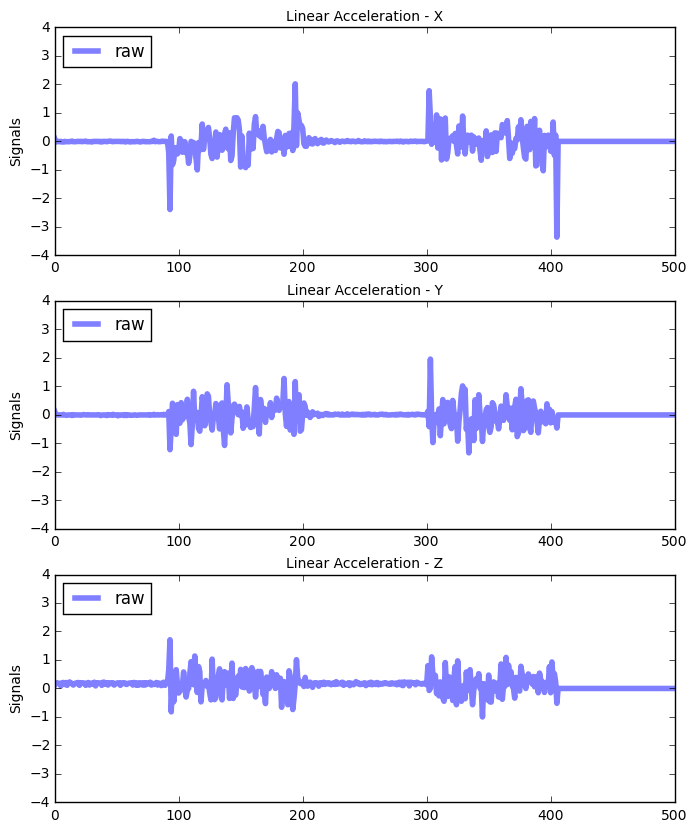

In [160]:
plot_raw_and_processed_data(
    raw_data,
    filtered_data=None,
    title_extra_str='Linear Acceleration',
    ylim=(-4,4))

### Cumulative Sum

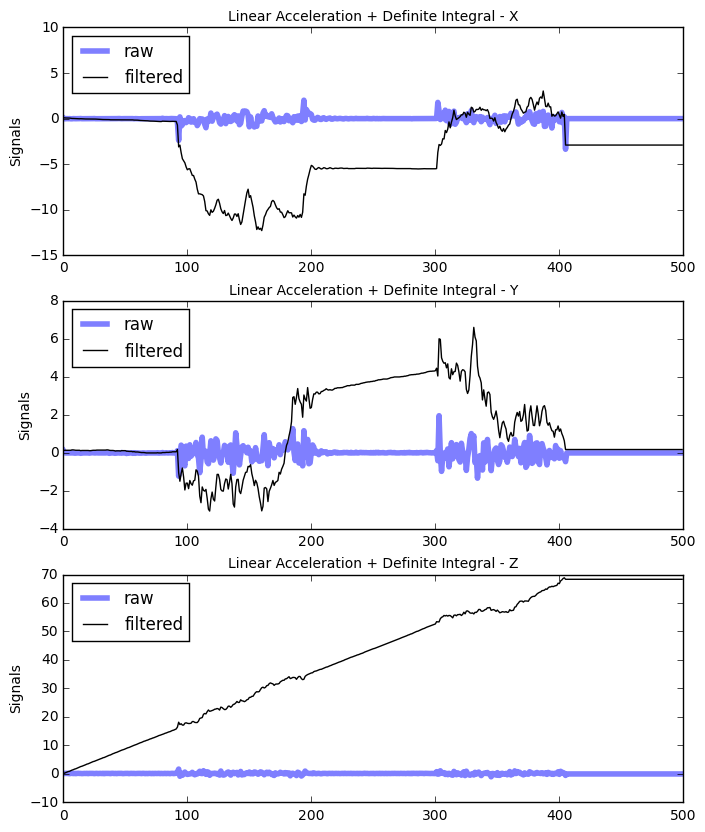

In [155]:
plot_raw_and_processed_data(
    raw_data,
    filtered_data=raw_data.cumsum(),
    title_extra_str='Linear Acceleration + Definite Integral',
    y1lim=(-15,10),y2lim=None,y3lim=None)

### Spectrograms

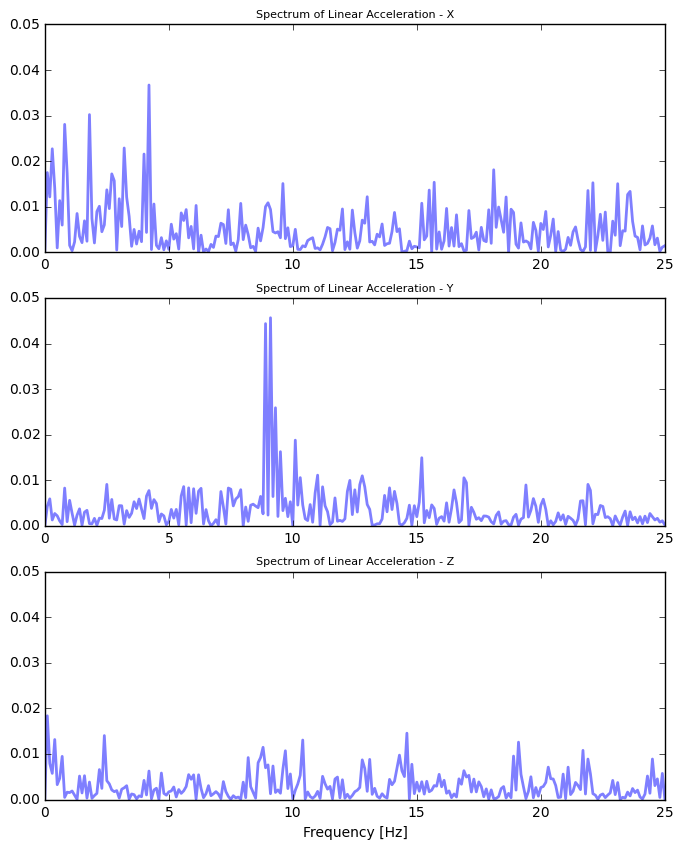

In [162]:
plot_spectrograms(
    raw_data,
    sampling_interval,
    title_extra_str='Spectrum of Linear Acceleration',
    do_log_scale=False,
    ylim=(0,.05),
    y1lim=None,
    y2lim=None,
    y3lim=None)

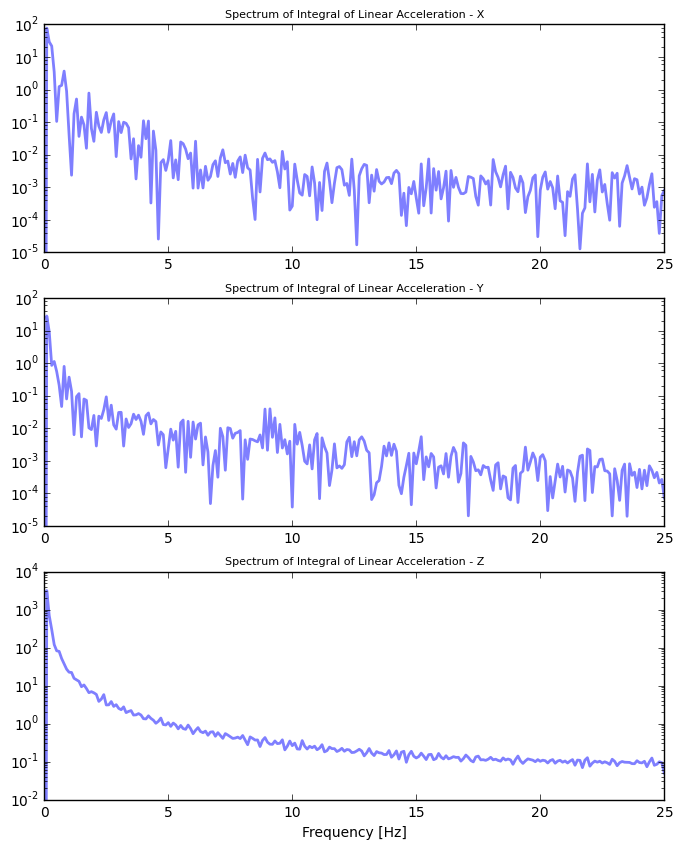

In [164]:
plot_spectrograms(
    raw_data.cumsum(),
    sampling_interval,
    title_extra_str='Spectrum of Integral of Linear Acceleration',
    do_log_scale=True,
    y1lim=(1e-5,1e2),
    y2lim=(1e-5,1e2),
    y3lim=(1e-2,1e4))

### Band Pass (or High Pass) - FIR

In [214]:
fs = 1/0.02
nyq = 0.5 * fs
ntaps = 127
window = 'hamming'
lowcut = 0.005 * nyq
highcut = 0.99 * nyq
# Band pass
#b = signal.firwin(ntaps, [lowcut, highcut], nyq=nyq, pass_zero=False,window=window, scale=False)
# High pass
b = signal.firwin(ntaps, lowcut, nyq=nyq, pass_zero=False,window=window, scale=False)
a = 1

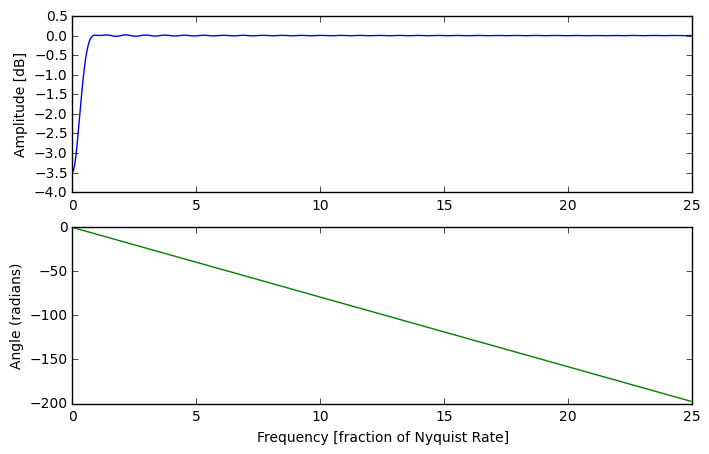

In [215]:
w, h = signal.freqz(b, a)

fig, axes = plt.subplots(figsize=(8,5),nrows=2, ncols=1)
current_axes = axes[0]
current_axes.plot(nyq*w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
#current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
#current_axes.set_ylim([-500,50])

angles = np.unwrap(np.angle(h))
current_axes = axes[1]
current_axes.plot(nyq*w/math.pi, angles, 'g')
current_axes.set_ylabel('Angle (radians)', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=10)

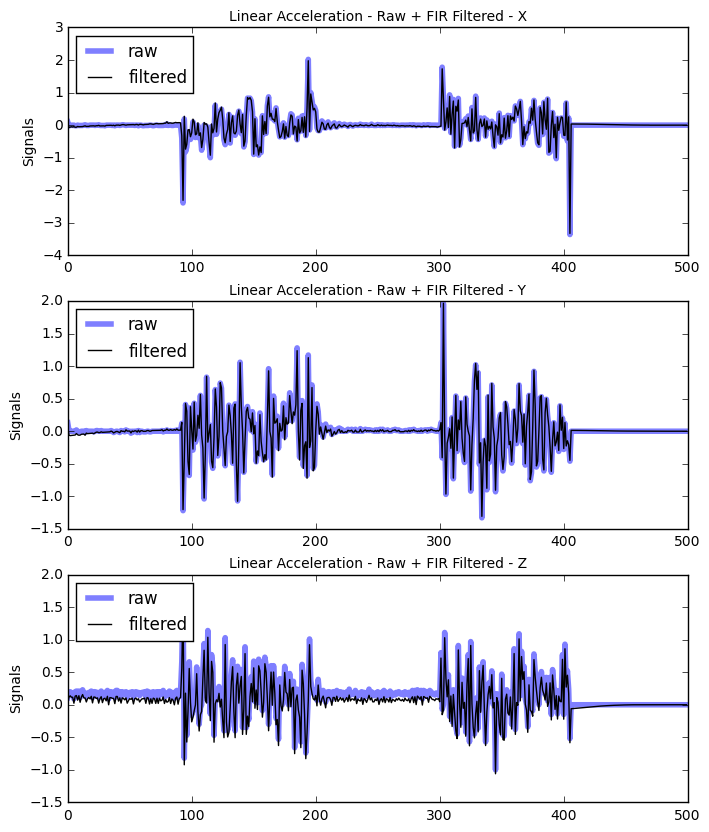

In [216]:
padtype = 'odd'
#method = 'gust'
method = 'pad'
padlen = 256
filt_data_x = signal.filtfilt(b,a,raw_data.x,padtype=padtype,padlen=padlen,method=method)
filt_data_y = signal.filtfilt(b,a,raw_data.y,padtype=padtype,padlen=padlen,method=method)
filt_data_z = signal.filtfilt(b,a,raw_data.z,padtype=padtype,padlen=padlen,method=method)
filtered_data = pd.DataFrame({'x':filt_data_x,'y':filt_data_y,'z':filt_data_z})

#filtered_data = raw_data

plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data,
    title_extra_str='Linear Acceleration - Raw + FIR Filtered')

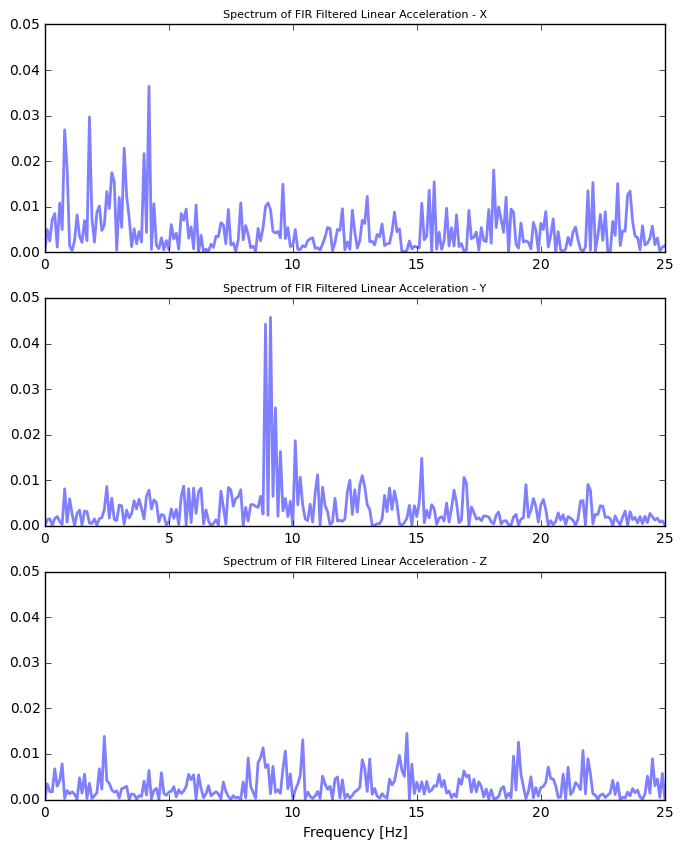

In [217]:
plot_spectrograms(
    filtered_data,
    sampling_interval,
    title_extra_str='Spectrum of FIR Filtered Linear Acceleration',
    do_log_scale=False,
    ylim=(0,.05),
    y1lim=None,
    y2lim=None,
    y3lim=None)

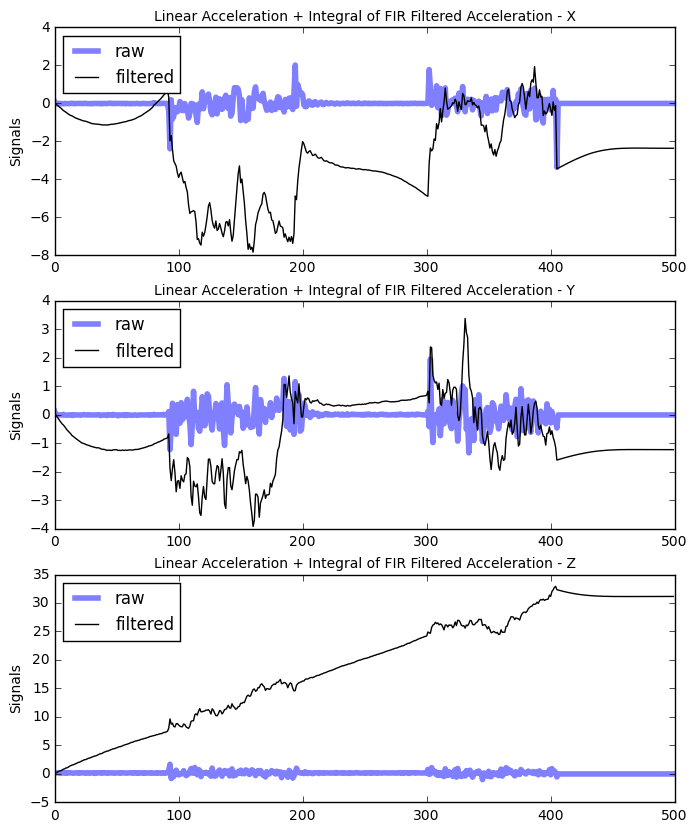

In [218]:
velocity_data = filtered_data.cumsum()
plot_raw_and_processed_data(
    raw_data,
    filtered_data=velocity_data,
    title_extra_str='Linear Acceleration + Integral of FIR Filtered Acceleration')

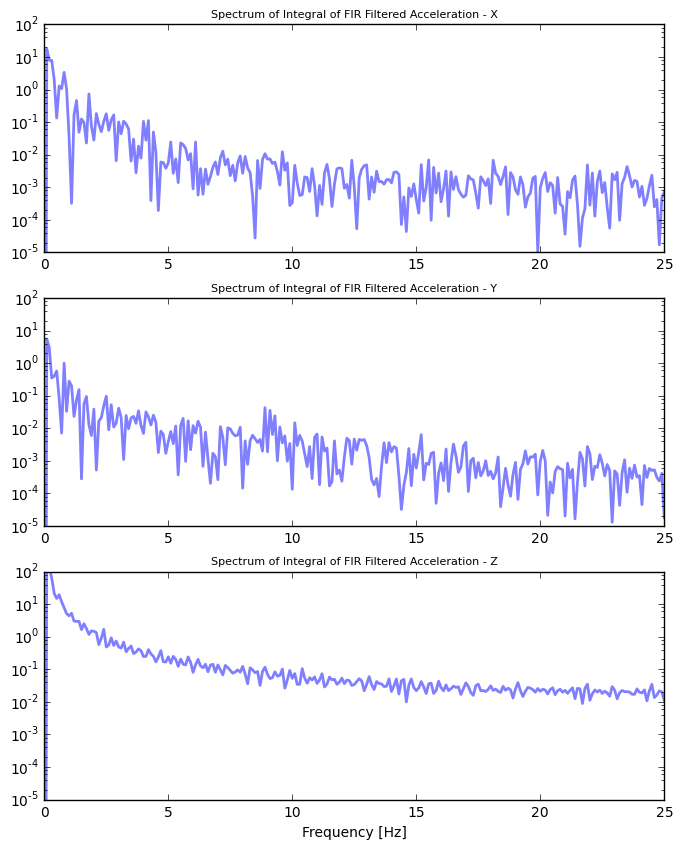

In [219]:
plot_spectrograms(
    velocity_data,
    sampling_interval,
    title_extra_str='Spectrum of Integral of FIR Filtered Acceleration',
    do_log_scale=True,
    y1lim=(1e-5,1e2),
    y2lim=(1e-5,1e2),
    y3lim=(1e-5,1e2))

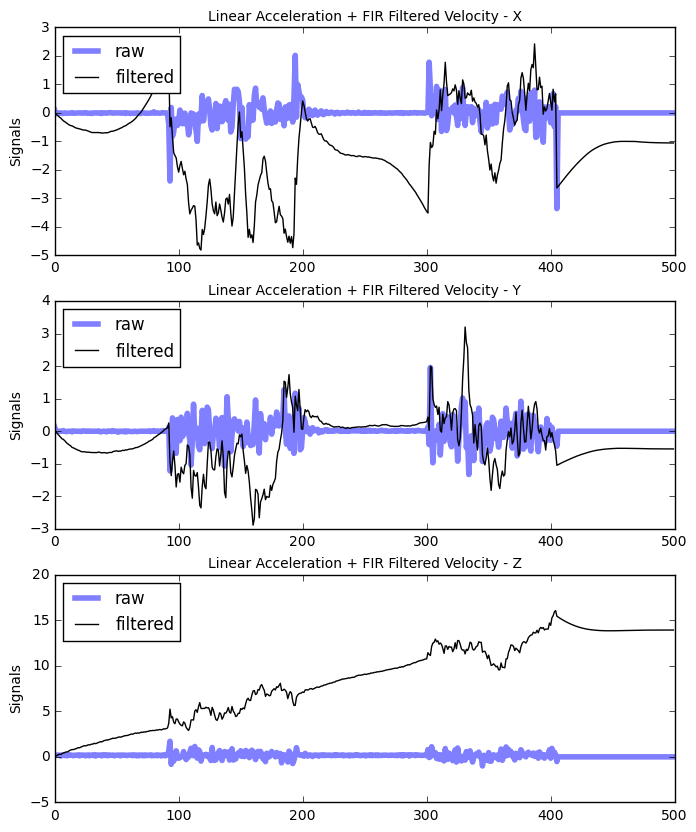

In [220]:
filt_data_x = signal.filtfilt(b,a,velocity_data.x,padtype=padtype,padlen=padlen,method=method)
filt_data_y = signal.filtfilt(b,a,velocity_data.y,padtype=padtype,padlen=padlen,method=method)
filt_data_z = signal.filtfilt(b,a,velocity_data.z,padtype=padtype,padlen=padlen,method=method)
filtered_data = pd.DataFrame({'x':filt_data_x,'y':filt_data_y,'z':filt_data_z})

plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data,
    title_extra_str='Linear Acceleration + FIR Filtered Velocity')

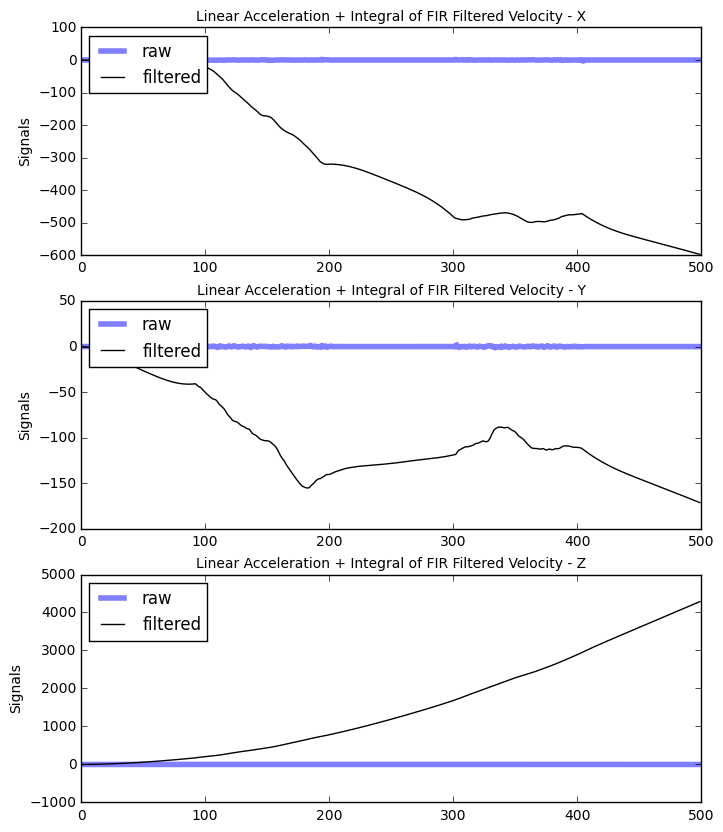

In [221]:
position_data = filtered_data.cumsum()
plot_raw_and_processed_data(
    raw_data,
    filtered_data=position_data,
    title_extra_str='Linear Acceleration + Integral of FIR Filtered Velocity')

### Band Pass - IIR

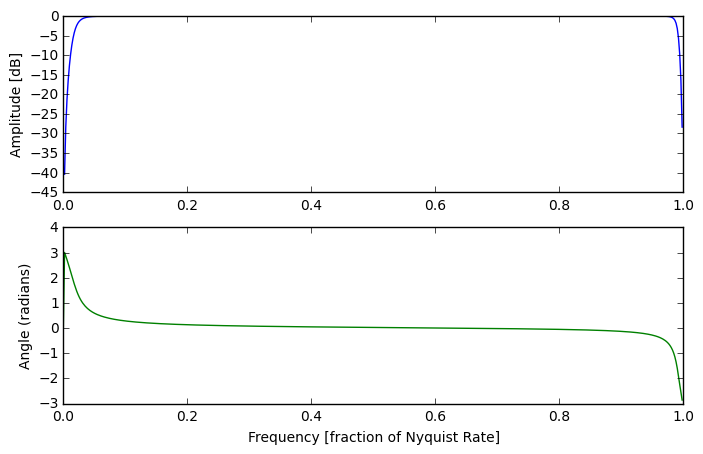

In [132]:
b, a = signal.butter(2, [0.02,0.99], 'bandpass', analog=False)
w, h = signal.freqz(b, a)

fig, axes = plt.subplots(figsize=(8,5),nrows=2, ncols=1)
current_axes = axes[0]
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
#current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
#current_axes.set_ylim([-500,50])

angles = np.unwrap(np.angle(h))
current_axes = axes[1]
current_axes.plot(w/math.pi, angles, 'g')
current_axes.set_ylabel('Angle (radians)', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=10)

In [133]:
padlen = 32
filt_data_x = signal.filtfilt(b,a,raw_data.x,padtype='odd',padlen=padlen)
filt_data_y = signal.filtfilt(b,a,raw_data.y,padtype='odd',padlen=padlen)
filt_data_z = signal.filtfilt(b,a,raw_data.z,padtype='odd',padlen=padlen)

filtered_data = pd.DataFrame({'x':filt_data_x,'y':filt_data_y,'z':filt_data_z})

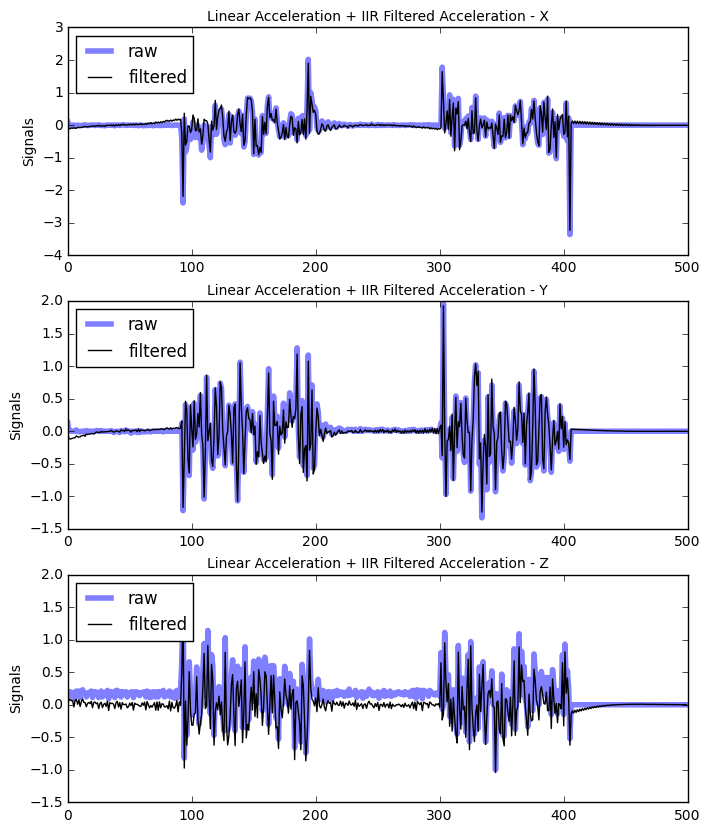

In [134]:
plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data,
    title_extra_str='Linear Acceleration + IIR Filtered Acceleration',
    y1lim=None,y2lim=None,y3lim=None)

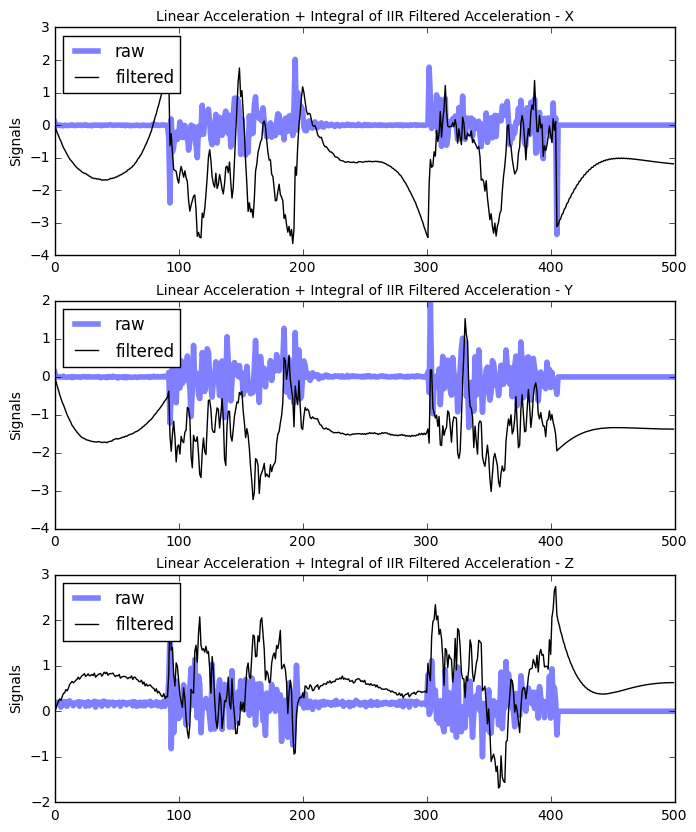

In [135]:
plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data.cumsum(),
    title_extra_str='Linear Acceleration + Integral of IIR Filtered Acceleration')

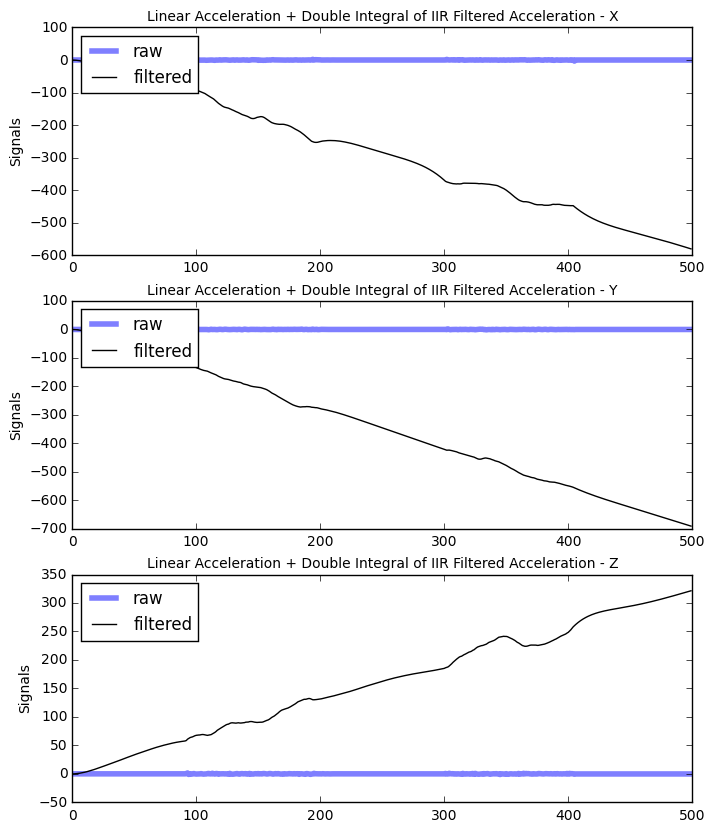

In [136]:
plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data.cumsum().cumsum(),
    title_extra_str='Linear Acceleration + Double Integral of IIR Filtered Acceleration')